<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow prat 3: Scaling up

We'll be scaling up to all 101 classes of food.

Our goal is to outperform the original Food101 paper (50.76%) with 10% of training data

https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

In [62]:
!nvidia-smi

Mon Oct 30 16:33:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    28W /  70W |   1831MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks we've created series of helper functions. Now we're going to import them

In [63]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-30 16:33:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-30 16:33:44 (120 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [64]:
# Import series of helper functions into our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

10% of the training data, let's download it.

In [65]:
# Get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the data
unzip_data("101_food_classes_10_percent.zip") # without .zip produces error

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-10-30 16:33:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.207, 172.217.219.207, 209.85.146.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  88.9MB/s    in 17s     

2023-10-30 16:34:00 (93.8 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [66]:
# How many images/classes
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75

In [67]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle the test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes dataset

StepsŁ
1. Setup a model checkpoint callback
2. Create a data augmentation layer to build data augmentation right into the model
3. Build a headless Functional EfficientNetB0 backboned model
4. Compile the model
5. Feature extract for 5 epochs and validate on 15% of the test data


In [68]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [69]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation as a layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(.2),
    preprocessing.RandomHeight(.2),
    preprocessing.RandomWidth(.2),
    preprocessing.RandomZoom(.2),
    # preprocessing.Rescale(1./255.) #when using EfficientNet not needed
], name="data_augmentation")

In [70]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable output layer
inputs = layers.Input(shape=(224, 224, 3), name="input")
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # in inference mode - stays frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(len(train_data_10_percent.class_names),
                       activation="softmax",
                       name="output")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 0s 0us/step


In [71]:
# Get the summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool (GlobalAve  (None, 1280)              0         
 ragePooling2D)                                                  
                                                                 
 output (Dense)              (None, 101)               129381    
                                                             

In [72]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [73]:
# Fit
history_1 = model.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_tensorboard_callback("experiments","10_percent_data"), checkpoint_callback])

Saving TensorBoard log files to: experiments/10_percent_data/20231030-163444
Epoch 1/5
237/237 [==============================] - 132s 522ms/step - loss: 3.3629 - accuracy: 0.2725 - val_loss: 2.5495 - val_accuracy: 0.4378
Epoch 2/5
237/237 [==============================] - 103s 432ms/step - loss: 2.1989 - accuracy: 0.4985 - val_loss: 2.0800 - val_accuracy: 0.5021
Epoch 3/5
237/237 [==============================] - 94s 393ms/step - loss: 1.8303 - accuracy: 0.5699 - val_loss: 1.9123 - val_accuracy: 0.5212
Epoch 4/5
237/237 [==============================] - 74s 302ms/step - loss: 1.6002 - accuracy: 0.6086 - val_loss: 1.8508 - val_accuracy: 0.5273
Epoch 5/5
237/237 [==============================] - 59s 248ms/step - loss: 1.4565 - accuracy: 0.6397 - val_loss: 1.8168 - val_accuracy: 0.5328


In [74]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 68s 86ms/step - loss: 1.5893 - accuracy: 0.5826


[1.5892566442489624, 0.5826138854026794]

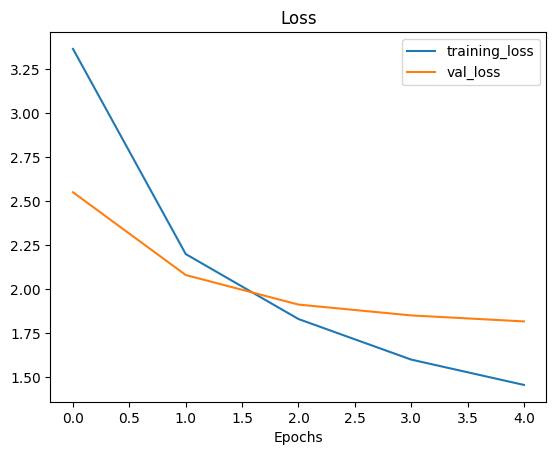

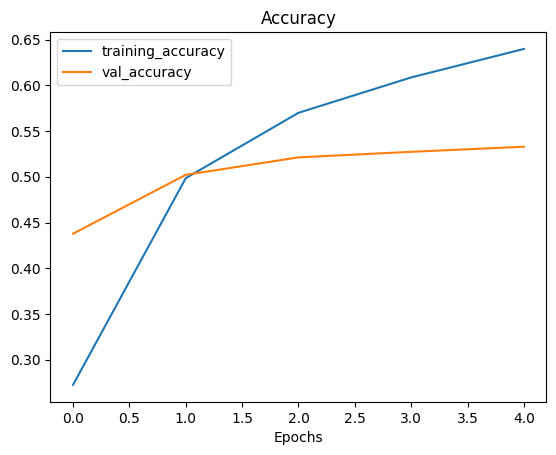

In [75]:
plot_loss_curves(history_1)

Overfitting HA!

## Fine Tuning

In [76]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze the bottom layers except the top 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [77]:
# Recompile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #10x lower lr
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [78]:
# Which layers are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input True
data_augmentation True
efficientnetb0 True
global_avg_pool True
output True


In [79]:
# Which layers are trainable in our base_model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [80]:
# Fit the model
initial_epochs = 5
total_epochs = initial_epochs + 5
history_2 = model.fit(train_data_10_percent,
                      epochs=total_epochs,
                      initial_epoch=history_1.epoch[-1],
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)))

Epoch 5/10
237/237 [==============================] - 69s 243ms/step - loss: 1.2091 - accuracy: 0.6825 - val_loss: 1.7676 - val_accuracy: 0.5426
Epoch 6/10
237/237 [==============================] - 53s 223ms/step - loss: 1.0968 - accuracy: 0.7060 - val_loss: 1.7193 - val_accuracy: 0.5450
Epoch 7/10
237/237 [==============================] - 50s 210ms/step - loss: 1.0111 - accuracy: 0.7251 - val_loss: 1.7200 - val_accuracy: 0.5530
Epoch 8/10
237/237 [==============================] - 48s 201ms/step - loss: 0.9460 - accuracy: 0.7471 - val_loss: 1.7717 - val_accuracy: 0.5352
Epoch 9/10
237/237 [==============================] - 46s 194ms/step - loss: 0.8996 - accuracy: 0.7542 - val_loss: 1.7634 - val_accuracy: 0.5429
Epoch 10/10
237/237 [==============================] - 48s 203ms/step - loss: 0.8307 - accuracy: 0.7752 - val_loss: 1.7619 - val_accuracy: 0.5426


In [81]:
# Evaluate on the whole data
results_2 = model.evaluate(test_data)
results_2

790/790 [==============================] - 68s 86ms/step - loss: 1.5054 - accuracy: 0.6022


[1.5053790807724, 0.6021782159805298]

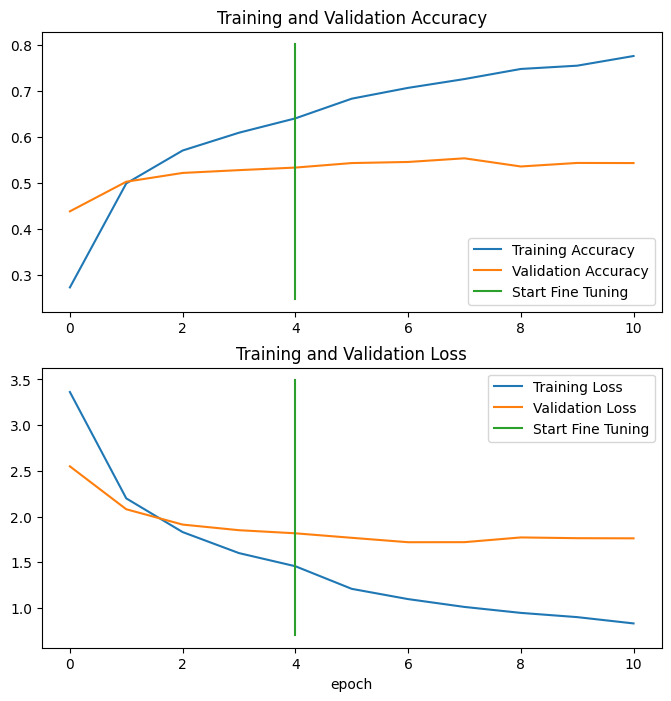

In [82]:
# Compare the histories
compare_historys(history_1, history_2, initial_epochs=5)

## Saving and loading our model

In [83]:
# Save the fine-tuned model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_saved_big_dog_model")

In [84]:
# Load and evaluate the whole model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_saved_big_dog_model")

In [85]:
# Evaluate the loaded model and compare to the pre saved one
results_2_1 = loaded_model.evaluate(test_data)
results_2_1

790/790 [==============================] - 66s 82ms/step - loss: 1.5054 - accuracy: 0.6022


[1.5053790807724, 0.6021782159805298]

In [86]:
results_2

[1.5053790807724, 0.6021782159805298]

## Evaluating the performance of the big dog model across all different classes

Make predictions and visualize them to find out which are the most wrong

In [87]:
import tensorflow as tf

# Importing Daniel's model to get the same results
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-10-30 16:53:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.207, 173.194.192.207, 209.85.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.2’

06_101_food_class_1 100%[===================>]  44.59M  86.6MB/s    in 0.5s    

2023-10-30 16:53:38 (86.6 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.2’ saved [46760742/46760742]



In [88]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [89]:
model_mdb = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [90]:
# Evaluate loaded model
results_mdb = model_mdb.evaluate(test_data)
results_mdb

790/790 [==============================] - 70s 85ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [91]:
# Making predictions with model
preds_probs = model_mdb.predict(test_data, verbose=1)

790/790 [==============================] - 70s 86ms/step


In [92]:
# How many predictions are there
len(preds_probs)

25250

In [93]:
# What's the shape of a prediction
preds_probs[0].shape

(101,)

In [94]:
preds_probs[:10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [95]:
# Prediction probability array with a probability value attached to each class
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

In [96]:
print(f"The class with the highest predicted probability for sample 0 is:\n {test_data.class_names[tf.argmax(preds_probs[0])]}")

The class with the highest predicted probability for sample 0 is:
 gyoza


In [97]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [98]:
# Get the test data labels
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())  #currently the labels are one-hot encoded where there's 1, we need the index to determine which class this is
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [99]:
# How many y_labels are there
len(y_labels)

25250

## Evaluating the models predictions



In [100]:
# SciKit Learn accuracy score
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [101]:
import numpy as np
np.isclose(sklearn_accuracy, results_mdb[1])

True

## Let's get visual: confusion matrix

In [102]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100))

## Classification report

In [103]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [104]:
# Create a plot of class-respective scores
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
class_names = test_data.class_names

In [105]:
# Create empty dict
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # Add class names and F1 scores to dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [106]:
# Turn f1 scores into a dataframe
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

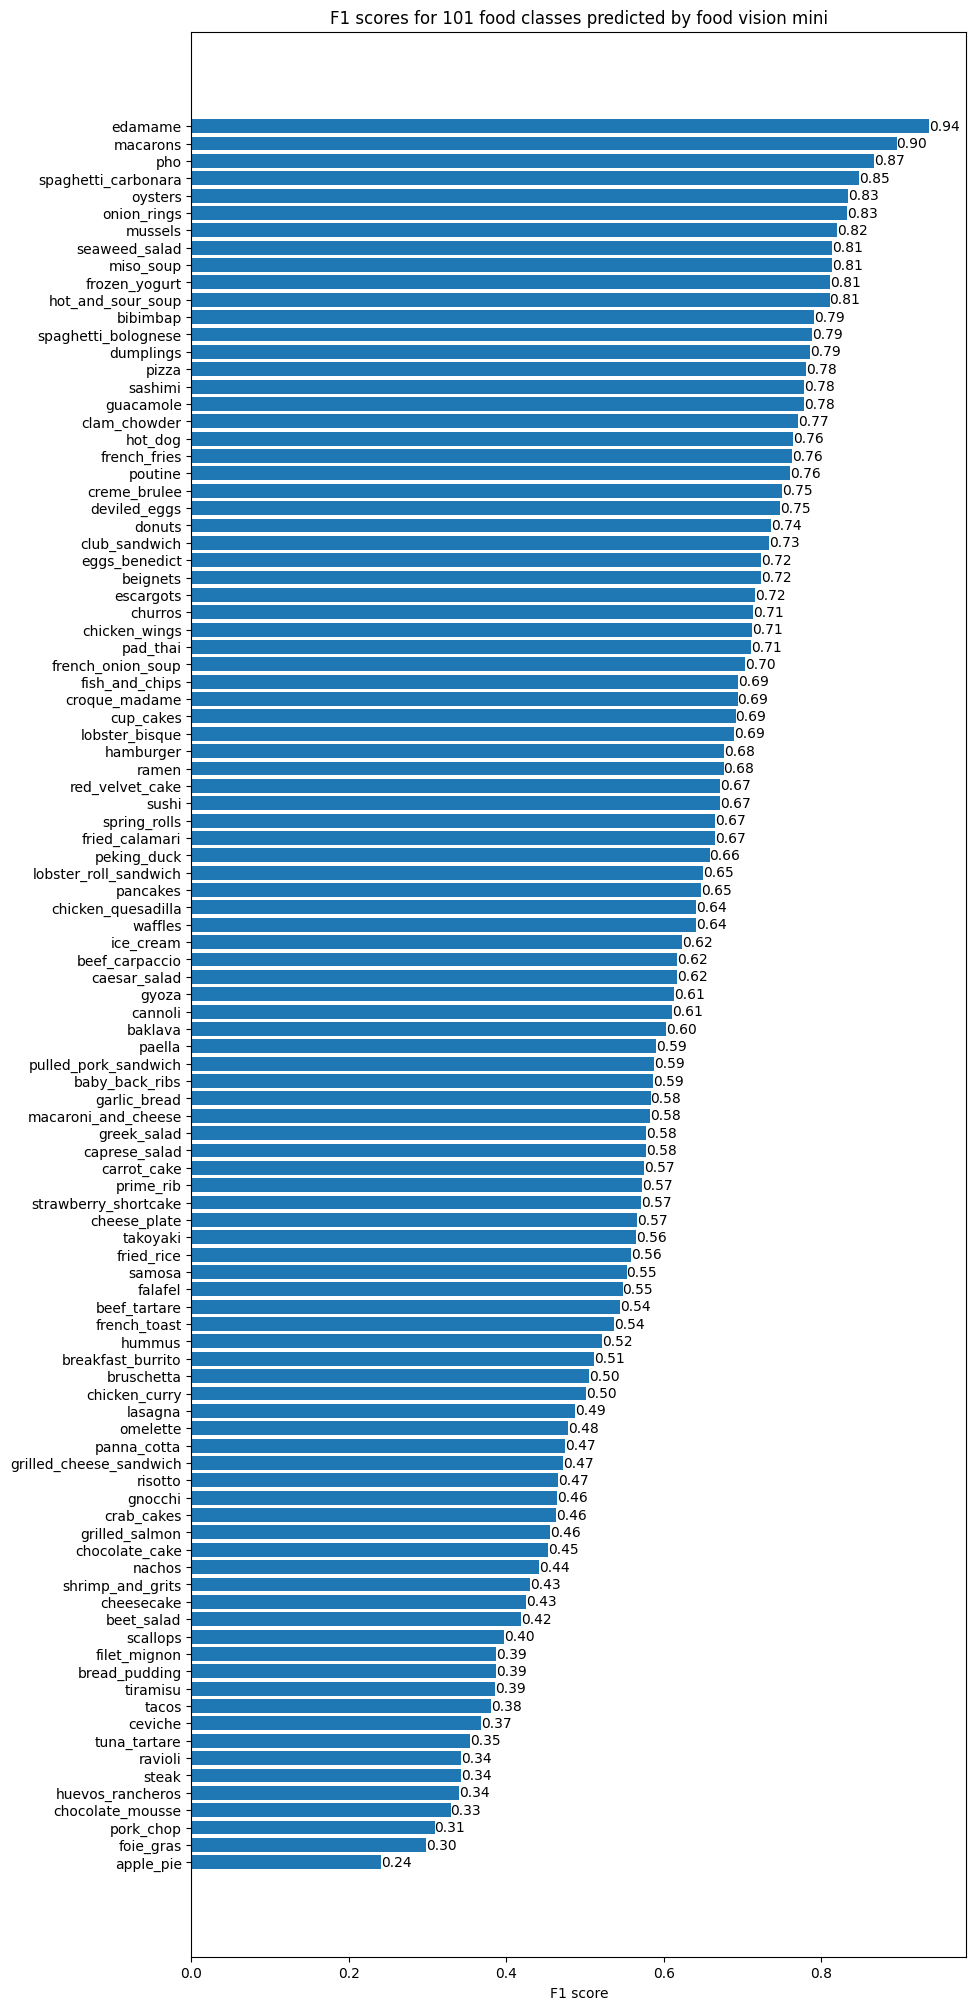

In [107]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,25))

scores = ax.barh(np.arange(len(f1_scores)), f1_scores["f1-score"].values) # we have as many slots as there are values and each one gets the respective f1 value
ax.set_yticks(np.arange(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1 score")
ax.set_title("F1 scores for 101 food classes predicted by food vision mini")
ax.invert_yaxis()
ax.bar_label(scores, fmt="%.2f");

## Visualizing predictions on custom images

Let's make a function to
* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a tensor using `tf.io.decode_image()`
* Resize the image to be the same size as the images in train and test data using `tf.image.resize()`
* Scale the image to get all the pixel values between o and 1 if necessary


In [118]:
# Create a function to load and prepare images
def load_and_prep_img(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape.

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of the target square image size
    scale (bool): whether or not to rescale the image so that the pixel values are between 0 and 1

  Returns:
   Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into a tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, (img_shape, img_shape))

  # Scale
  if scale:
    # Rescale the image (get all values from between 0 and 255 to between 0 and 1)
    return img/255.
  else:
    return img # for EfficientNet not necessary

1. Load random images from the test dataset
2. Make predictions
3. Plot the images, predictions and correct labels

1/1 [==============================] - 0s 30ms/step


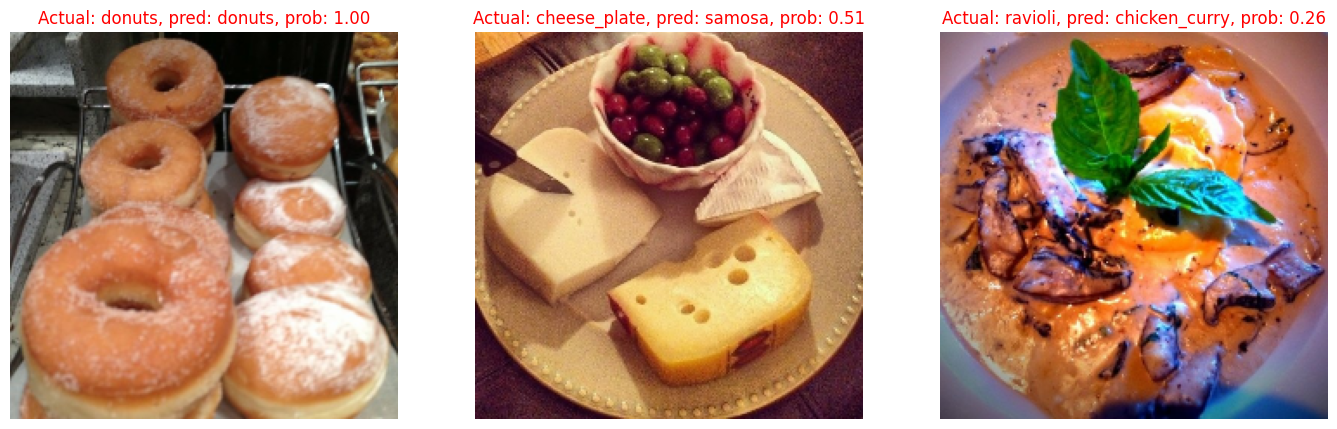

In [120]:
# Make predictions on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  # Choose a random file
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load image
  img = load_and_prep_img(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model_mdb.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]

  # Plot the images
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_names == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);


## Finding the most wrong predictions

1. Get all the image file paths in the test dataset using list_files() method
2. Create a pandas dataframe of the image filepaths, ground truth labels, predicted classes, max prediction probabilities, prediction class names, true class names
3. Use the dataframe to find all the wrong predictions
4. Sort the dataframe based on wrong predictions
5. Visualize the images with the highest prediction probabilities but have the wrong prediction



In [123]:
# Get all of the image filepaths in the test dataset
filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [124]:
# Create a df on different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658606        apple_pie  pulled_pork_sandwich  
4       0.367900        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690628          waffles               waffles  

[25250 rows x 6 columns]

In [125]:
# Find in our dataframe which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true_classname"] == pred_df["y_pred_classname"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847419        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658606        apple_pie  pulled_pork_sandwich         False  
4   0.367900        apple_pie             prime_rib         False

In [126]:
# Sort our dataframe to have the most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong[:20]

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

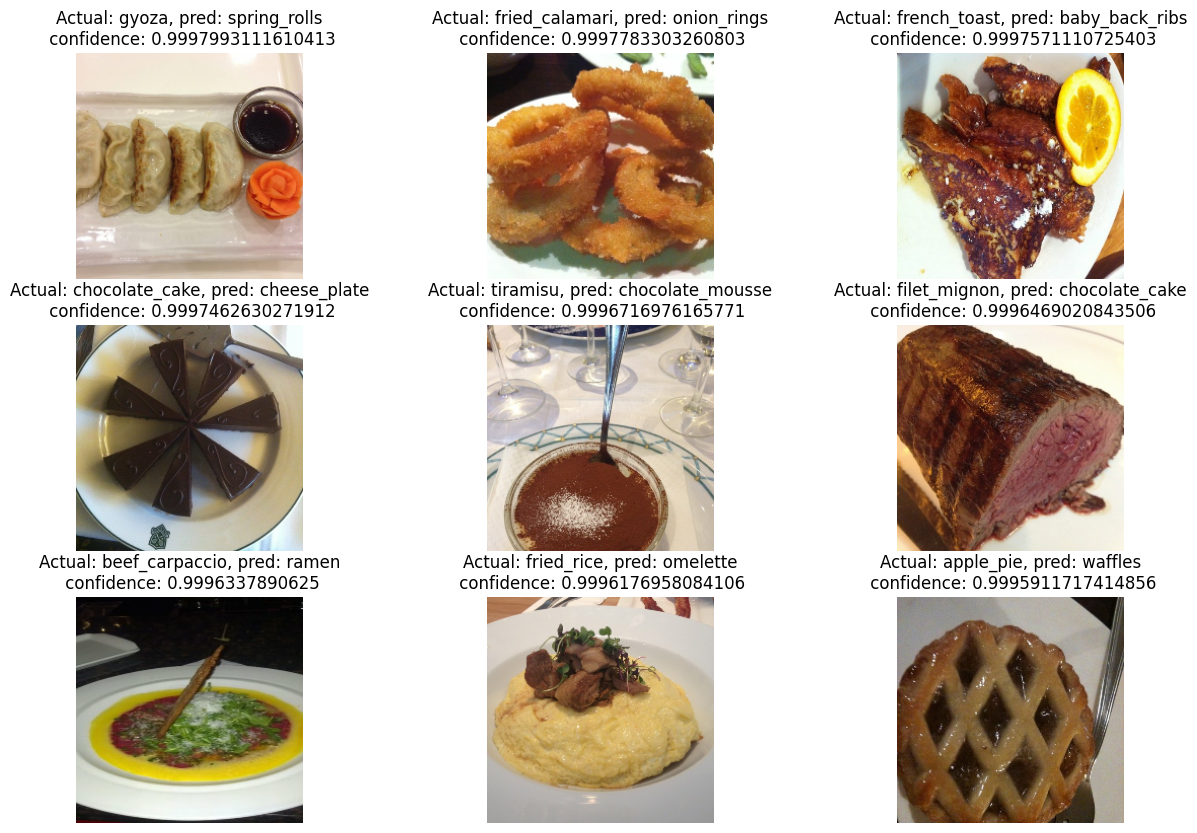

In [134]:
# Visualize the data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 18
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_img(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"Actual: {y_true_classname}, pred: {y_pred_classname}\n confidence: {pred_prob}");
  plt.axis(False)

## Making predictions on custom images

In [135]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2023-10-30 17:54:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.207, 142.250.136.207, 142.250.148.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  43.4MB/s    in 0.3s    

2023-10-30 17:54:57 (43.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [137]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images/")]

1/1 [==============================] - 0s 42ms/step


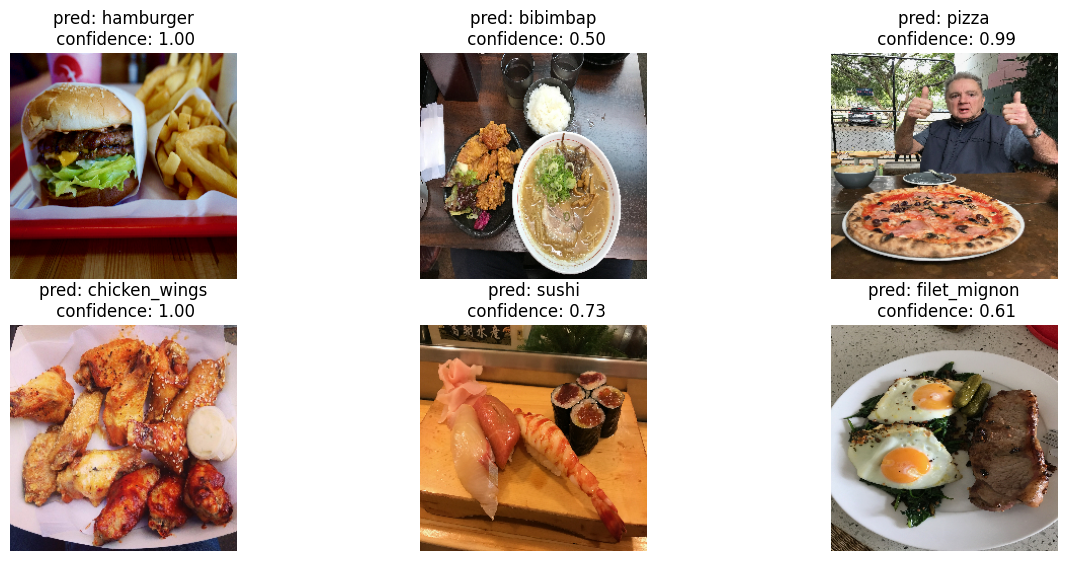

In [141]:
# Make and plot custom food images
plt.figure(figsize=(15, 10))
for i, img in enumerate(custom_food_images):
  img = load_and_prep_img(img, scale=False)
  pred_prob = model_mdb.predict(tf.expand_dims(img, axis=0)) # The model takes in images in batches so additional dimension needed
  pred_class = class_names[pred_prob.argmax()]
  # Plot the appropriate info
  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}\n confidence: {pred_prob.max():.2f}");
  plt.axis(False);